In [1]:
import numpy as np
from numpy.random import exponential
import matplotlib.pyplot as plt
import matplotlib
from lmfit import Model
from lmfit.models import LinearModel, PowerLawModel
from pandas import DataFrame, read_csv

In [2]:
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Sample an exponential distribution

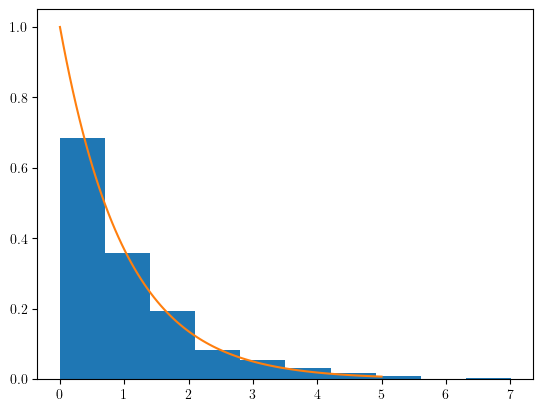

In [3]:
sampled = np.random.rand(1000)
transform_u = lambda u, A: -np.log(u)/A
x = np.linspace(0, 5, 100)

plt.hist(transform_u(sampled, 1), density=True)
plt.plot(x, np.exp(-x))
plt.savefig('../deliverables/figures/exp_dist.pdf')

## Monte-Carlo Simulation

In [4]:
initial_energy = 1e+3
brem_crit = 6.9
ion_loss_rate = 2.
radiation_length = 5.80
mat_thickness = 10.
mat_density = 11.4
# mat_radiation_length = mat_thickness * mat_density
mat_radiation_length = 10. * radiation_length
n_trials = 100

In [45]:
def cascade_trial(
        radiation_length=5.80,
        mat_thickness=10.,
        mat_density=11.4,
        initial_energy=1e+3, 
        ion_loss_rate=2.,
        brem_crit=6.9,
        m_e=0.511,
        max_particles=1000000
    ):
    photons = np.zeros((max_particles, 5))
    photons[:, 4] = -1
    photon_count = 1 # number of photons that have ever been created

    charged = np.zeros((max_particles, 5))
    charged[:, 4] = -1
    charged[0, 4] = 1
    charged_count = 0 # number of charged particles that have ever been created

    brem_events = 0
    pair_events = 0

    photons[0, 0] = initial_energy
    photons[0, 4] = 1

    # mat_radiation_length = mat_thickness * mat_density
    mat_radiation_length = 10. * radiation_length
    # 0: energy, 1: distance, 2: active
    def loop_criteria(photons, charged, mat_radiation_length=mat_radiation_length):
        return np.logical_or(
            ((photons[photons[:, 4] > 0, 2] + photons[photons[:, 4] > 0, 3]) < mat_radiation_length).any(),
            ((charged[charged[:, 4] > 0, 2] + charged[charged[:, 4] > 0, 3]) < mat_radiation_length).any()
        )

    while loop_criteria(photons, charged).any():
        # photon effects
        productive = (photons[:, 0] + photons[:, 1]) > 2 * m_e 
        pair_events += len(photons[productive])
        photon_travel = exponential(size=max_particles, scale=(9/7)*radiation_length)
        photons[photons[:, 4] > 0, 3] += photon_travel[photons[:, 4] > 0]

        new_pairs = np.zeros(photons[productive].shape)
        new_pairs[:, 0] = (photons[productive, 0] + photons[productive, 1]) / 2
        new_pairs[:, 2] = photons[productive, 2]
        new_pairs[:, 4] = 1
        new_pairs = np.repeat(new_pairs, 2, axis=0)
        charged[charged_count:charged_count+new_pairs.shape[0], :] = new_pairs
        charged_count += new_pairs.shape[0]

        # make the pair-production photons' energy zero
        photons[productive, 1] = -photons[productive, 0]
        photons[productive, 4] = 0

        # charged particle effects
        in_mat = np.logical_and(
            (charged[:, 2] + charged[:, 3]) < mat_radiation_length,
            charged[:, 4] > 0
        )

        bremming = np.logical_and((charged[:, 0] + charged[:, 1]) > brem_crit, in_mat)
        charge_travel = exponential(size=max_particles, scale=radiation_length)
        new_positions_in_mat = np.where(in_mat, charged[:, 2] + charged[:, 3], 0.) + np.where(in_mat, charge_travel, 0.)
        excess = new_positions_in_mat - mat_radiation_length
        # calculate the distance traveled for all charged particles
        # in the medium for this monte-carlo step
        travel_in_medium = np.where(
            excess > 0,
            charge_travel - excess,
            charge_travel
        )
        # print((travel_in_medium[in_mat] / radiation_length).mean())
        E0 = charged[bremming, 0] + charged[bremming, 1]
        brem_energy = E0 * np.exp(-charged[bremming, 3] / radiation_length) * (travel_in_medium[bremming] / radiation_length)
        # brem_energy = charged[bremming, 0] * (1 - np.exp(-travel_in_medium[bremming] / radiation_length))

        charged[bremming, 1] -= brem_energy # has no check for negative energy. can I get away with this?
        charged[in_mat, 1] -= ion_loss_rate * travel_in_medium[in_mat]

        # charges that are partially inside before escaping on the next step out will
        # lose energy to ionization proportional to the distance traveled inside
        # np.where conserves the size of the charged array for consistent indexing
        charged[charged[:, 4] > 0, 3] += charge_travel[charged[:, 4] > 0]

        # ensure energy is never negative
        spent_particles = (charged[:, 0] + charged[:, 1]) < 0
        # "refund" the length caused by going into negative energy
        charged[spent_particles, 3] += (charged[spent_particles, 0] + charged[spent_particles, 1]) / ion_loss_rate
        charged[spent_particles, 1] = -charged[spent_particles, 0]
        charged[spent_particles, 4] = 0

        brem_photons = np.zeros(charged[bremming].shape)
        brem_photons[:, 0] = brem_energy
        brem_photons[:, 2] = charged[bremming, 2]
        brem_photons[:, 4] = 1

        photons[photon_count:photon_count+brem_photons.shape[0], :] = brem_photons
        photon_count += brem_photons.shape[0]
        brem_events += brem_photons.shape[0]

    return photons, charged, brem_events, pair_events

(array([3.000e+00, 2.000e+00, 3.000e+00, 1.000e+01, 1.000e+01, 2.500e+01,
        8.500e+01, 5.450e+02, 2.095e+03, 8.000e+00]),
 array([-76.64361648, -67.01146598, -57.37931549, -47.74716499,
        -38.1150145 , -28.48286401, -18.85071351,  -9.21856302,
          0.41358748,  10.04573797,  19.67788846]),
 <BarContainer object of 10 artists>)

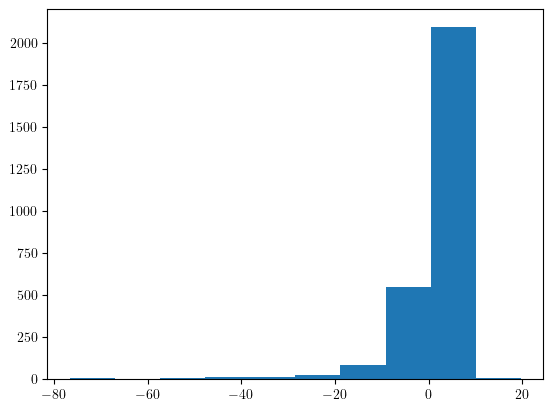

In [49]:
plt.hist(total_charged[:, 2] + total_charged[:, 3])

In [46]:
total_charged = []
total_photons = []
for i in range(1):
    photons, charged, brem_events, pair_events = cascade_trial()
    total_charged.append(charged[charged[:, 4] > -1, :])
    total_photons.append(photons[photons[:, 4] > -1, :])
    
total_charged = np.vstack(total_charged)
total_photons = np.vstack(total_photons)

In [210]:
charged_save = DataFrame(total_charged, columns=['I. Energy (MeV)', 'D. Energy (MeV)', 'I. Depth (g/cm2)', 'D. Depth (g/cm2)', 'Active'])
charged_save.to_csv('data/charged_1000.csv', index=False)

photon_save = DataFrame(total_charged, columns=['I. Energy (MeV)', 'D. Energy (MeV)', 'I. Depth (g/cm2)', 'D. Depth (g/cm2)', 'Active'])
photon_save.to_csv('data/photon_1000.csv', index=False)

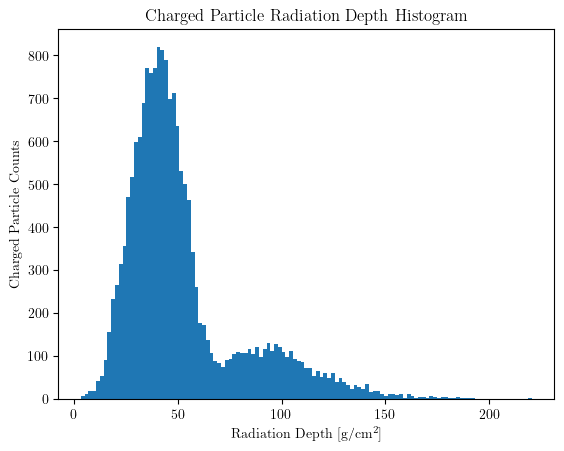

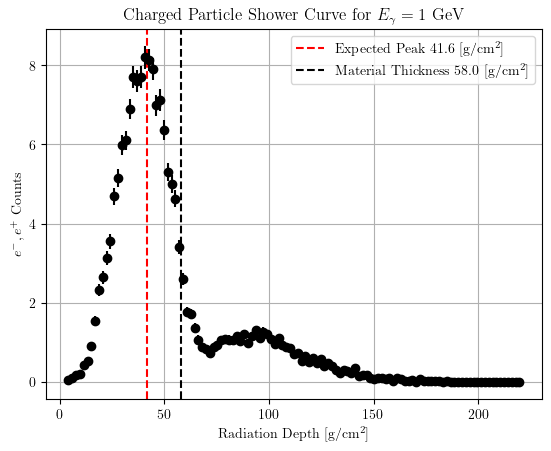

In [211]:
total_charged = read_csv('data/charged_1000.csv')
total_photons = read_csv('data/photon_1000.csv')

charge_depths = total_charged['I. Depth (g/cm2)'] + total_charged['D. Depth (g/cm2)']
bin_counts, bin_edges, _ = plt.hist(charge_depths, density=False, bins='auto', label=f'Trials = {n_trials}');
bin_counts /= n_trials
plt.xlabel('Radiation Depth [g/cm$^2$]')
plt.ylabel('Charged Particle Counts')
plt.title('Charged Particle Radiation Depth Histogram')
plt.savefig('../deliverables/figures/charged_depth_hist.pdf')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

fig, ax = plt.subplots()
ax.grid()
# ax.scatter(bin_centers, bin_counts, color='black', label='Data')
ax.errorbar(bin_centers, bin_counts, yerr=np.sqrt(bin_counts / n_trials), fmt='o', color='black')
ax.set_xlabel('Radiation Depth [g/cm$^2$]')
ax.set_ylabel('$e^-,e^+$ Counts')
ax.set_title('Charged Particle Shower Curve for $E_\\gamma = 1$ GeV')

expected_peak = np.log(initial_energy / brem_crit) / np.log(2.) * radiation_length
ax.axvline(expected_peak, color='red', linestyle='--', label=f'Expected Peak {expected_peak:.3} [g/cm$^2$]')
ax.axvline(mat_radiation_length, color='k', linestyle='--', label=f'Material Thickness {mat_radiation_length} [g/cm$^2$]')

ax.legend()

fig.savefig('../deliverables/figures/charged_depth_results.pdf')

- errorbars of a histogram [Histograms](https://www.quarknet.org/sites/default/files/histogram_uncertainty_tchr_31oct19.pdf):
> When collecting data by counting, the underlying statistical distribution is a Poisson distribution
because counting can never be negative. Since particle physicists perform counting experiments, the
uncertainty in a count is determined using the standard deviation for the Poisson distribution $$\sqrt{N}$$

## Other analyses
- Modeling how fit parameters vary with bin count/width
- Plotting shower curve area to initial photon energy

Text(0.5, 1.0, 'Cascade Spectrum for $E_\\gamma = 1$ GeV')

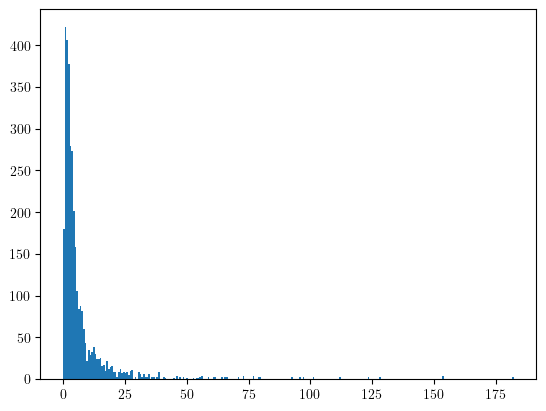

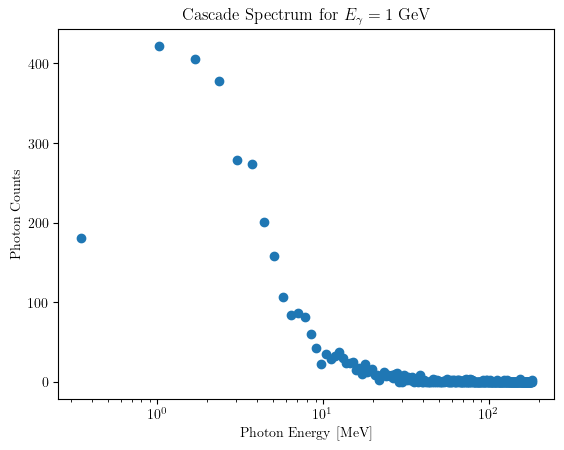

In [213]:
photons = total_photons['I. Energy (MeV)']
energy_counts, energy_bins, _ = plt.hist(photons, density=False, bins='auto');
energy_centers = (energy_bins[1:] + energy_bins[:-1])/2

fig2, ax2 = plt.subplots()
ax2.semilogx(energy_centers, energy_counts, 'o')
ax2.set_xlabel('Photon Energy [MeV]')
ax2.set_ylabel('Photon Counts')
ax2.set_title('Cascade Spectrum for $E_\\gamma = 1$ GeV')

In [214]:
shower_curve_area = np.trapz(bin_counts, bin_centers)
shower_curve_area

315.7643521134494

## Convergence Testing with Bin counts

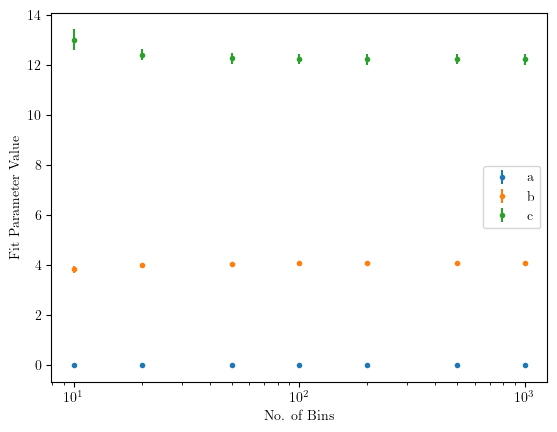

In [215]:
total_charged = read_csv('data/charged.csv')
total_photons = read_csv('data/photon.csv')

def fit_function(x, a, b, c):
    return a * x ** b * np.exp(-x / c)

n_bins = np.array([10, 20, 50, 100, 200, 500, 1000])
a_arr = []
a_err = []
b_arr = []
b_err = []
c_arr = []
c_err = []

for n_bin in n_bins:
    charge_depths = total_charged['I. Depth (g/cm2)'] + total_charged['D. Depth (g/cm2)']
    bin_counts, bin_edges = np.histogram(charge_depths, bins=n_bin)
    bin_counts = np.divide(bin_counts, n_trials)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2


    x = bin_centers
    y = bin_counts

    fit_model = Model(fit_function)
    params = fit_model.make_params(a=8e-3, b=4., c=13)
    results = fit_model.fit(y, params, x=x)
    a_arr.append(results.params['a'].value)
    a_err.append(results.params['a'].stderr)
    b_arr.append(results.params['b'].value)
    b_err.append(results.params['b'].stderr)
    c_arr.append(results.params['c'].value)
    c_err.append(results.params['c'].stderr)

a_arr = np.array(a_arr)
b_arr = np.array(b_arr)
c_arr = np.array(c_arr)

fig, ax = plt.subplots()
ax.errorbar(n_bins, a_arr, yerr=a_err, fmt='o', label='a', markersize=3)
ax.errorbar(n_bins, b_arr, yerr=b_err, fmt='o', label='b', markersize=3)
ax.errorbar(n_bins, c_arr, yerr=c_err, fmt='o', label='c', markersize=3)
ax.set_xscale('log')
ax.set_xlabel('No. of Bins')
ax.set_ylabel('Fit Parameter Value')
ax.legend()

fig.savefig('../deliverables/figures/fit_parameter_convergence.pdf')

## Plotting initial photon energy and shower curve area

In [216]:
# incoming_energies = np.logspace(1, 4, 10)
incoming_energies = np.array([1, 10, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000])
for e in incoming_energies:
    total_charged = []
    total_photons = []
    for i in range(n_trials):
        photons, charged, brem_events, pair_events = cascade_trial(initial_energy=e)
        total_charged.append(charged[charged[:, 2] > -1, :])
        total_photons.append(photons[photons[:, 2] > -1, :])
        
    total_charged = np.vstack(total_charged)
    total_photons = np.vstack(total_photons)

    energy_int = str(int(e))
    charged_save = DataFrame(total_charged, columns=['I. Energy (MeV)', 'D. Energy (MeV)', 'I. Depth (g/cm2)', 'D. Depth (g/cm2)', 'Active'])
    charged_save.to_csv(f'data/charged_{energy_int}.csv', index=False)

    photon_save = DataFrame(total_charged, columns=['I. Energy (MeV)', 'D. Energy (MeV)', 'I. Depth (g/cm2)', 'D. Depth (g/cm2)', 'Active'])
    photon_save.to_csv(f'data/photon_{energy_int}.csv', index=False)

0.0
0.0
0.69
2.46
17.08
39.63999999999999
103.08000000000001
155.89000000000001
207.65999999999997
245.18999999999997
299.61999999999995
405.25
472.31


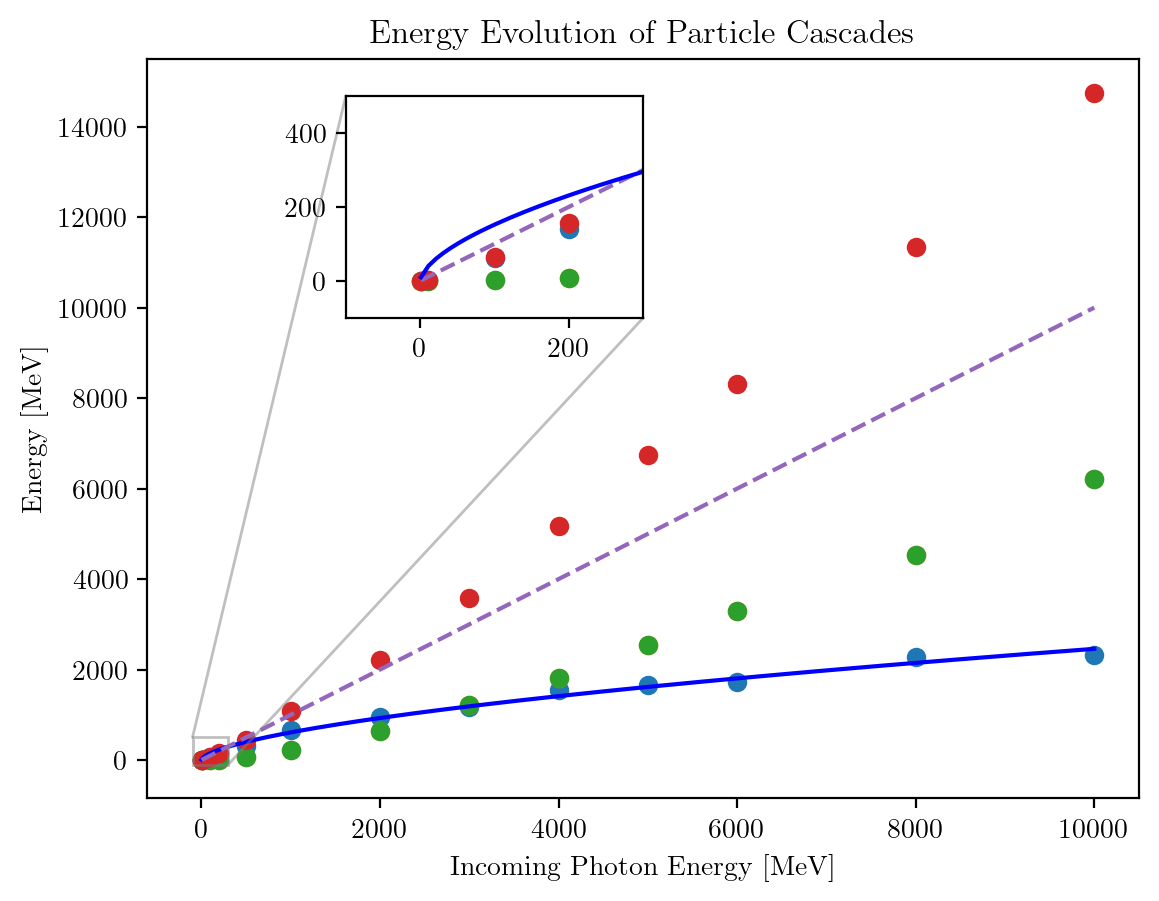

In [12]:
# incoming_energies = np.logspace(1, 4, 10)
incoming_energies = np.array([1, 10, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000])
shower_areas = []
photon_energies = []
charged_energies = []
for e in incoming_energies:
    energy_int = str(int(e))
    total_charged = read_csv(f'data/charged_{energy_int}.csv')
    total_photons = read_csv(f'data/photon_{energy_int}.csv')
    bin_counts, bin_edges = np.histogram(total_charged['Depth (g/cm2)'], bins=100)
    bin_counts = np.divide(bin_counts, n_trials)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    # integrate shower curve inside the block of lead
    in_mat_counts = bin_counts[bin_centers < mat_radiation_length]
    in_mat_centers = bin_centers[bin_centers < mat_radiation_length]
    in_mat_contribution = ion_loss_rate * np.trapz(in_mat_counts, in_mat_centers)

    # add ionization contributions from particles that left
    # the block of lead
    escaped_counts = bin_counts[bin_centers >= mat_radiation_length].sum()
    print(escaped_counts)
    escaped_contribution = ion_loss_rate * mat_radiation_length * escaped_counts
    shower_areas.append(in_mat_contribution)

    # shower_areas.append(ion_loss_rate * np.trapz(bin_counts, bin_centers))

    remaining_charges = total_charged.to_numpy()
    remaining_charges = remaining_charges[remaining_charges[:, 2] > 0, 0]
    charged_energies.append(remaining_charges.sum() / n_trials)

    remaining_photons = total_photons.to_numpy()
    remaining_photons = remaining_photons[remaining_photons[: ,2] > 0, 0]
    photon_energies.append(remaining_photons.sum() / n_trials)

shower_areas = np.array(shower_areas)
photon_energies = np.array(photon_energies)
charged_energies = np.array(charged_energies)

total_energies = shower_areas + photon_energies + charged_energies

x = incoming_energies
y = shower_areas

# inc_model = LinearModel()
inc_model = PowerLawModel()
params = inc_model.make_params(slope=1, intercept=1)
results = inc_model.fit(y, params, x=x)
x_fit = np.linspace(
    incoming_energies.min(),
    incoming_energies.max(),
    1000
)

fig, ax = plt.subplots(dpi=200)
ax.plot(incoming_energies, shower_areas, 'o', label='Ionization Loss')
ax.plot(incoming_energies, photon_energies, 'o', label='Cascading Photon Energy')
ax.plot(incoming_energies, charged_energies, 'o', label='Cascading Charge Energy')
ax.plot(incoming_energies, total_energies, 'o', label='Total Energy')
ax.plot(x_fit, inc_model.eval(results.params, x=x_fit), label='Ionization Loss Fit', color='blue')
ax.plot(x_fit, x_fit, linestyle='--', label='Energy Conservation Line')

axin = ax.inset_axes([0.2, 0.65, 0.3, 0.3])
axin.set_xlim(-100, 300)
axin.set_ylim(-100, 500)
ax.indicate_inset_zoom(axin)
axin.plot(incoming_energies, shower_areas, 'o')
axin.plot(incoming_energies, photon_energies, 'o')
axin.plot(incoming_energies, charged_energies, 'o')
axin.plot(incoming_energies, total_energies, 'o')
axin.plot(x_fit, x_fit, linestyle='--')
axin.plot(x_fit, inc_model.eval(results.params, x=x_fit), color='blue')
ax.set_xlabel('Incoming Photon Energy [MeV]')
ax.set_ylabel('Energy [MeV]')
ax.set_title('Energy Evolution of Particle Cascades')
# ax.legend()

fig.savefig('../deliverables/figures/shower_area_vs_energy.pdf')